# Imports

In [1]:
import glob
import os
import struct
import time
import bottleneck

import numpy as np
import pylab as plt
import scipy.ndimage as spImage
import sklearn.linear_model as sklLinear
import sklearn.kernel_ridge as sklKRR

%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 30.0)

# Utility

## Utility functions

In [2]:
def distort(A, scale):
  if scale == 0:
    return A
  return np.clip(A + np.random.normal(scale=scale, size=A.shape), 0, 1)

In [3]:
def plot_many(shape, n_cols, *imgs):
  imgs = np.array(imgs)
  imgs = imgs.reshape(-1, *shape)
  n_imgs = imgs.shape[0]
  n_rows = (n_imgs + n_cols - 1) / n_cols

  f = plt.figure()
  for i, img in enumerate(imgs):
    row = i % n_rows
    col = i / n_rows
    f.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
    plt.imshow(-img, cmap='Greys', interpolation='none')
  plt.show()

In [4]:
def L2(X):
  return np.sqrt(np.sum(X**2))

In [5]:
def L2_squared(X):
  return np.sum(X**2)

In [6]:
def MSE(X, Y):
  return L2_squared(X - Y) / X.shape[0]

In [7]:
def normalize(X):
  X = X.T
  X -= np.min(X, axis=0)
  X /= np.max(X, axis=0)
  return X.T

In [8]:
def difference_matrix(X, Y):
  D = np.zeros((X.shape[0], Y.shape[0], Y.shape[1]))
  for i in xrange(X.shape[0]):
    D[i] = X[i] - Y
  return D

In [9]:
def rbf(X, Y, sigma=400):
  D = np.zeros((X.shape[0], Y.shape[0]))
  for i in xrange(X.shape[0]):
    D[i] = np.sum((X[i] - Y)**2, axis=1)
  return np.exp(-.5 * D / sigma)

In [10]:
def drbf(X, Y, sigma=400):
  D = difference_matrix(X, Y)
  F = np.exp(-.5 * np.sum(D**2, axis=2) / sigma)
  J = -D.transpose(2, 0, 1) / sigma
  for i in range(J.shape[0]):
    J[i] *= F
  return F, J.transpose(1, 2, 0)

## Timer

In [11]:
class Timer:
  def __init__(self, msg):
    self.msg = msg
    self.interrupted = False

  def __enter__(self):
    print "Started " + self.msg
    self.t = time.time()

  def __exit__(self, type_, value_, traceback_):
    if type_ is None:
      print "Finished " + self.msg + " " + self._format(time.time() - self.t)
    else:
      print "Interrupted " + self.msg + " after " + self._format(time.time() - self.t)

  def _format(self, t):
    if t >= 60:
      m = int(t / 60)
      s = int(t - 60 * m)
      return "%dm %ds" % (m, s)
    return "%.2fs" % t


# SOAR

In [12]:
class SOAR:
  def __init__(self, kernel, alpha=1, batch_size=80, predict_epochs=300, predict_tol=1e-7, verbose=0):
    self.kernel = kernel
    self.alpha = alpha
    self.batch_size = batch_size
    self.predict_epochs = predict_epochs
    self.predict_tol = predict_tol
    self.verbose = verbose
    
  def fit(self, neutral, smiling):
    self.n, self.d = smiling.shape
    
    self.neutral = neutral
    self.smiling = smiling

    self.fit_epochs = (self.n + self.batch_size - 1) / self.batch_size
    
    if self.verbose > 0:
      print 'Training with batch_size={} in {} epochs'.format(self.batch_size, self.fit_epochs)
    
    self.a = np.zeros((self.n, self.d))
    for i in range(self.fit_epochs):
      fr = i * self.batch_size
      to = (i + 1) * self.batch_size
      neutral_idxs = neutral[fr:to]
      smiling_idxs = smiling[fr:to]
      I_n = self.alpha * np.eye(neutral_idxs.shape[0])
      self.kernel.set_x(neutral_idxs, neutral_idxs)   # (n, n)
      self.kernel.set_y(smiling_idxs, smiling_idxs)   # (n, n)
      for j in range(self.d):
        if self.verbose > 0 and j % self.verbose == 0:
          print 'Training feature {} at epoch {}'.format(j, i)
        self.a[fr:to,j] = (np.linalg.inv(self.kernel(j) + I_n)
                           .dot(smiling_idxs[:,j]))
    self.a = self.a.T
        
    return self

  def predict(self, X, Y0=None):
    Y1 = X if Y0 is None else Y0
    self.kernel.set_x(X, self.neutral)
    for _ in range(self.predict_epochs):
      self.kernel.set_y(Y1, self.smiling)
      Y2 = np.zeros(Y1.shape)
      for j in range(self.d):
        Y2[:,j] = self.kernel(j).dot(self.a[j])
      Y2 = normalize(Y2)
      d = MSE(Y1, Y2)
      if self.verbose > 0 and _ % self.verbose == 0:
        print 'Iteration #{} d={}'.format(_, d)
      if d < self.predict_tol:
        break
      Y1 = Y2
    return Y1

# Faces

## Constants

In [32]:
FACES_DIM = 9216
FACES_SHAPE = (96, 96)

NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

FACES_SPLIT = 150
FACES_REPEAT = 5
FACES_DISTORTION = .05

## Load Faces

In [33]:
def read_faces(faces_glob):
  faces = []
  for filename in sorted(glob.glob(faces_glob)):
    faces.append(spImage.imread(filename, flatten=True).flatten())
  return np.array(faces) / 255

neutral = read_faces(NEUTRAL_FACES_GLOB)
smiling = read_faces(SMILING_FACES_GLOB)

p = np.random.permutation(neutral.shape[0])
neutral = neutral[p]
smiling = smiling[p]

## Split into input/output and training/testing

In [34]:
def flip_faces(faces):
  return faces.reshape(-1, *FACES_SHAPE)[:,:,::-1].reshape(-1, FACES_DIM)

neutral_training = np.append(neutral[:FACES_SPLIT], smiling[:FACES_SPLIT], axis=0)
smiling_training = np.append(smiling[:FACES_SPLIT], smiling[:FACES_SPLIT], axis=0)

neutral_training = np.append(neutral_training, flip_faces(neutral_training), axis=0)
smiling_training = np.append(smiling_training, flip_faces(smiling_training), axis=0)

neutral_training = distort(np.repeat(neutral_training, FACES_REPEAT, axis=0), FACES_DISTORTION)
smiling_training = np.repeat(smiling_training, FACES_REPEAT, axis=0)
  
neutral_test = normalize(neutral[FACES_SPLIT:])# np.append(neutral[SPLIT_1:], smiling[SPLIT_1:], axis=0)
smiling_test = normalize(smiling[FACES_SPLIT:])# np.append(smiling[SPLIT_1:], smiling[SPLIT_1:], axis=0)

## Load faces not part of the dataset

In [35]:
some_woman = spImage.imread('some_woman.jpeg', flatten=True).reshape(1, 9216) / 255
some_guy = spImage.imread('some_guy.jpeg', flatten=True).reshape(1, 9216) / 255
obama = spImage.imread('obama.jpeg', flatten=True).reshape(1, 9216) / 255
lemur_face = spImage.imread('lemur_face.jpeg', flatten=True).reshape(1, 9216) / 255
panther_face = spImage.imread('../panther.jpeg', flatten=True).reshape(1, 9216) / 255

# Idea

In [36]:
class Idea:
  def __init__(self, d=32, alpha=1):
    self.d = d
    self.alpha = alpha
        
  def fit(self, X, Y):
    n, d = X.shape
    
    X = X.reshape(-1, self.d*FACES_SHAPE[0])
    Y = Y.reshape(-1, self.d*FACES_SHAPE[0])
    
    self.W = sklLinear.Ridge(alpha=self.alpha).fit(X, Y)
    
    return self
  
  def predict(self, X):
    n, d = X.shape
    Y = self.W.predict(X.reshape(-1, self.d*FACES_SHAPE[0])).reshape(n, d)
    return Y

In [37]:
baseline_idea = sklLinear.Ridge(alpha=0.1).fit(neutral_training, smiling_training)

In [38]:
baseline = normalize(baseline_idea.predict(neutral_test))

In [39]:
idea = Idea(alpha=0, d=32).fit(neutral_training, smiling_training)

In [40]:
pred = normalize(idea.predict(neutral_test))

In [41]:
idea2 = Idea(alpha=40, d=32).fit(neutral_training, smiling_training-neutral_training)

In [42]:
pred2 = normalize(idea2.predict(neutral_test) + neutral_test)

In [43]:
idea3 = sklLinear.Ridge(alpha=40).fit(neutral_training, smiling_training-neutral_training)

In [44]:
pred3 = normalize(idea3.predict(neutral_test)+neutral_test)

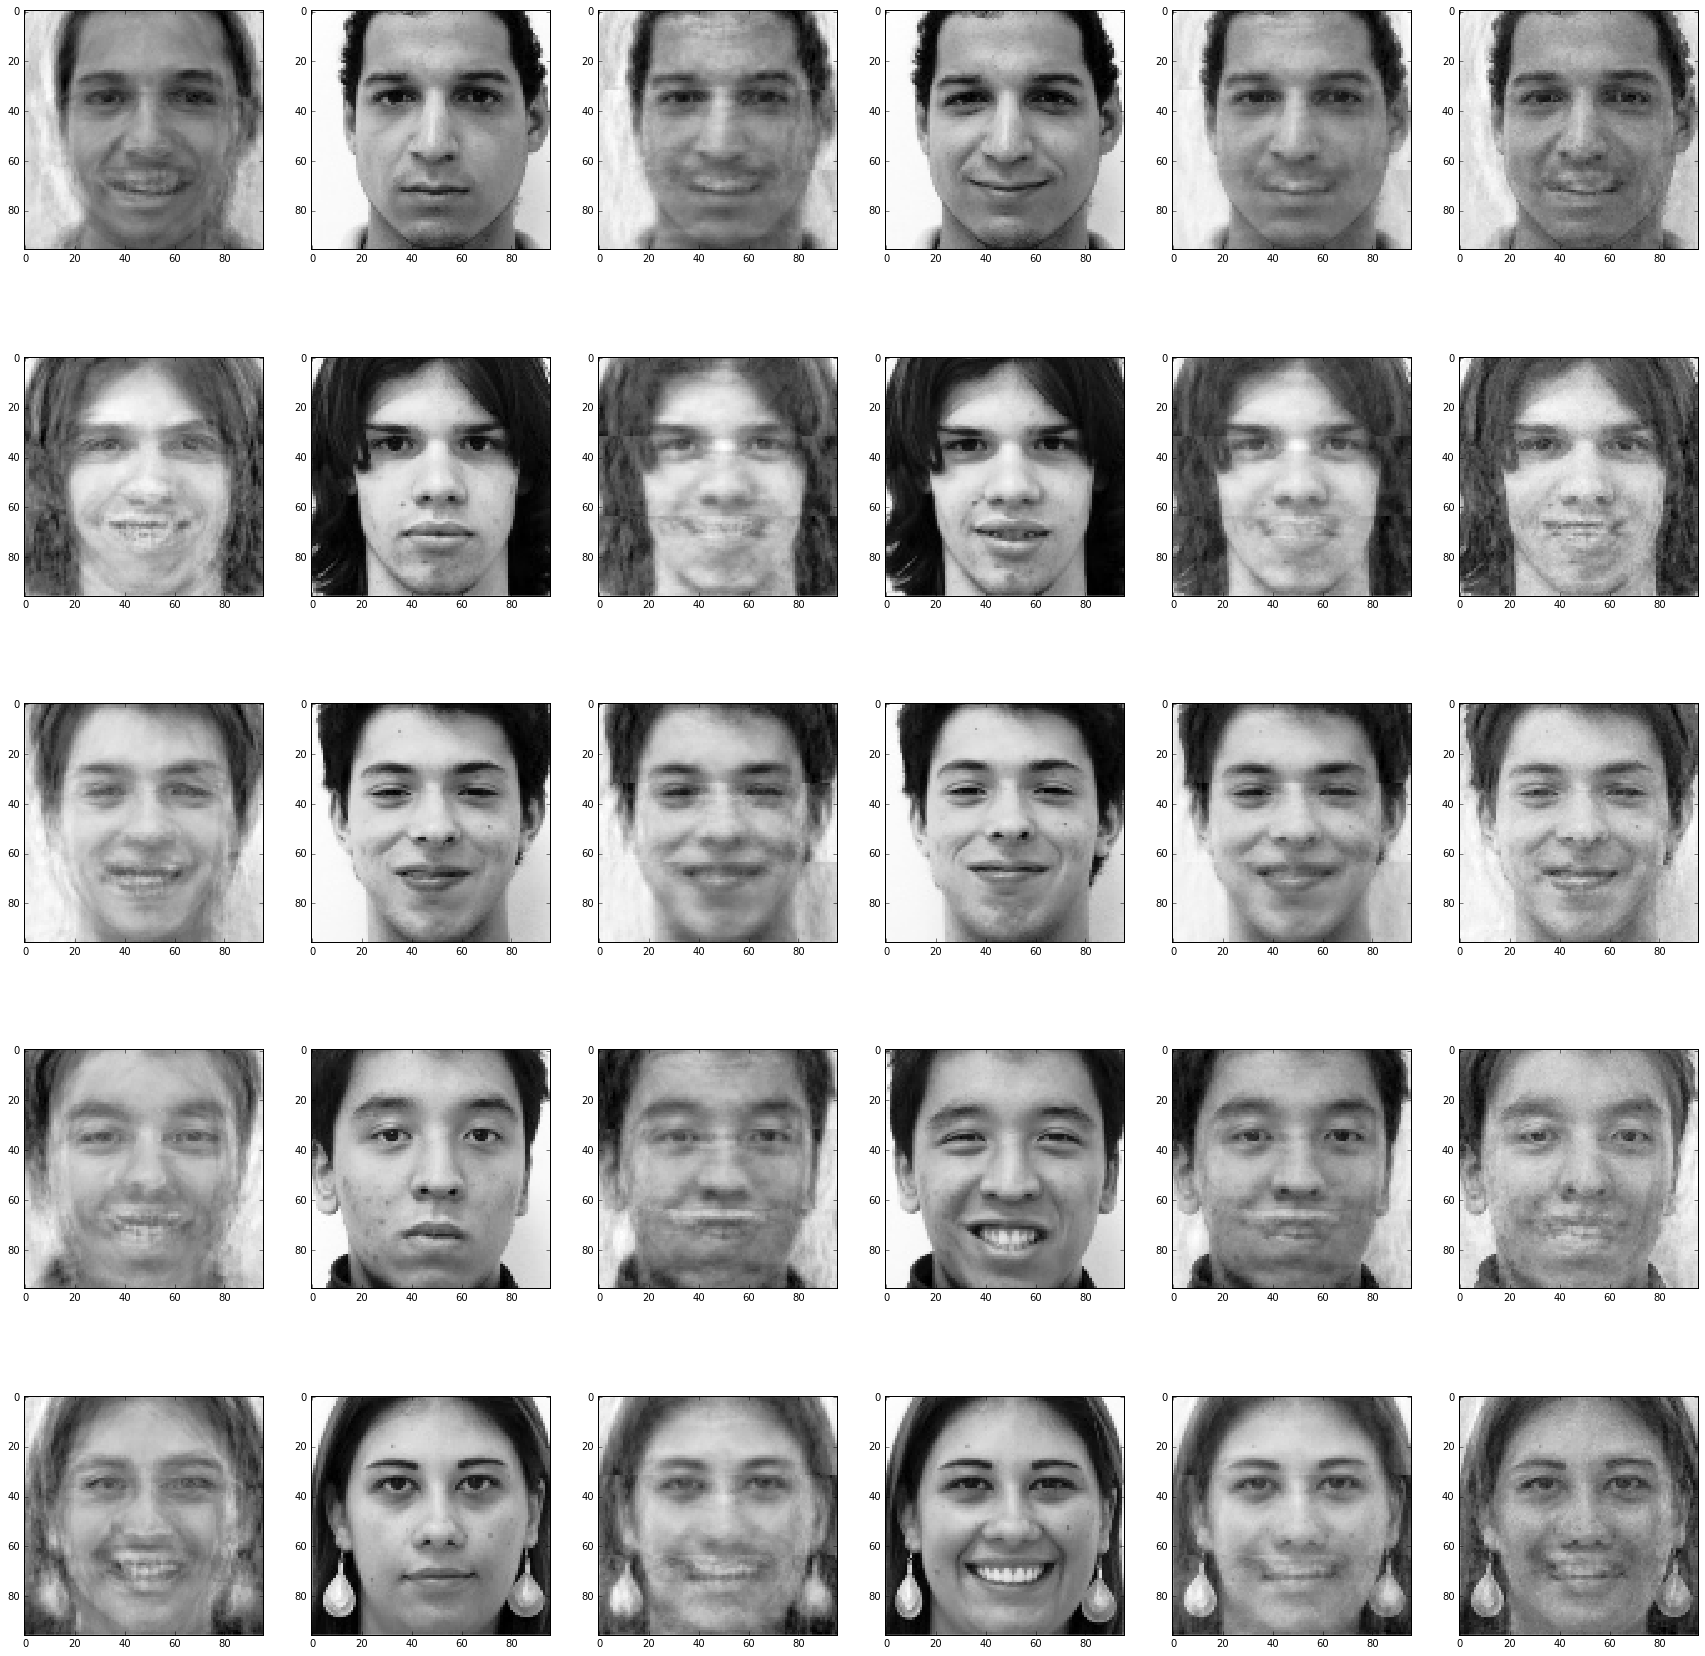

171.540294525
139.9287511
114.459660251
141.579271883


In [45]:
plot_many(FACES_SHAPE, 6, baseline[:5], neutral_test[:5], pred[:5], smiling_test[:5], pred2[:5], pred3[:5])
print MSE(smiling_test, baseline)
print MSE(smiling_test, pred)
print MSE(smiling_test, pred2)
print MSE(smiling_test, pred3)

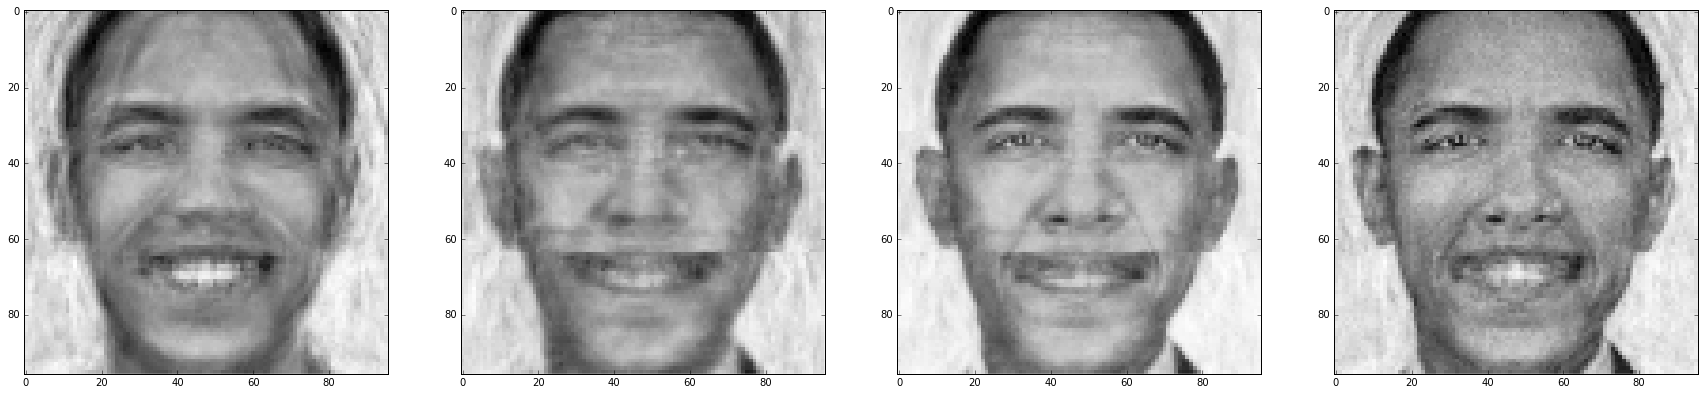

In [46]:
plot_many(FACES_SHAPE, 4, baseline_idea.predict(obama), idea.predict(obama), idea2.predict(obama) + obama, idea3.predict(obama) + obama)

# MNIST

## Constants

In [ ]:
MNIST_DIM = 784
MNIST_SHAPE = (28, 28)

MNIST_HDIM = 392
MNIST_HSHAPE = (28, 14)

MNIST_TRAINING = 'train-images-idx3-ubyte'
MNIST_TEST = 't10k-images-idx3-ubyte'

MNIST_SPLIT = 14
MNIST_REPEAT = 1
MNIST_DISTORTION = 0

## Load digits

In [ ]:
def read_mnist(filename):
  with open(filename, 'rb') as f:
    magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
    return np.fromfile(f, dtype=np.uint8).astype(np.float_).reshape(num, rows, cols) / 255

mnist_training = read_mnist(MNIST_TRAINING)
mnist_test = read_mnist(MNIST_TEST)

## Split into input/output and training/testing

In [ ]:
mnist_training_l = mnist_training[:,:,:MNIST_SPLIT].reshape(-1, MNIST_HDIM)
mnist_training_r = mnist_training[:,:,MNIST_SPLIT:].reshape(-1, MNIST_HDIM)

mnist_test_l = mnist_test[:,:,:MNIST_SPLIT].reshape(-1, MNIST_HDIM)
mnist_test_r = mnist_test[:,:,MNIST_SPLIT:].reshape(-1, MNIST_HDIM)

mnist_training = mnist_training.reshape(-1, MNIST_DIM)
mnist_test = mnist_test.reshape(-1, MNIST_DIM)

In [ ]:
def mnist_join(left, right):
  return np.append(left.reshape(-1, *MNIST_HSHAPE), right.reshape(-1, *MNIST_HSHAPE),
                   axis=2).reshape(-1, MNIST_DIM)

## Ridge Regression

In [ ]:
class MNIST_RidgeRegression:
  def __init__(self, beta=1):
    self.beta = beta
  def set_x(self, X1, X2):
    self.X1 = X1.T
    self.X2 = X2.T
    self.X = self.X1.T.dot(self.X2) + 1
  def set_y(self, Y1, Y2):
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    ks = []
    r = k / 14
    c = k % 14
    if c > 0: ks += [k - 1]
    if c < 13: ks += [k + 1]
    if r > 0: ks += [k - 14]
    if r < 27: ks += [k + 14]
    Ky = self.Y1[ks].T.dot(self.Y2[ks])
    if c == 0: Ky += np.outer(self.X1[k+13], self.X2[k+13])
    return (self.X + 1)**3 + self.beta * Ky

In [ ]:
with Timer("Training (dot + 1)**2 + beta"):
  rr = (SOAR(MNIST_RidgeRegression(beta=10), batch_size=1000, alpha=100)
        .fit(mnist_training_l[:3000], mnist_training_r[:3000]))
  rr.verbose = 20
  rrp = rr.predict(mnist_test_l[:100])
  
with Timer("Training (dot + 1)**2"):
  rr2 = (SOAR(MNIST_RidgeRegression(beta=0), batch_size=1000, alpha=100)
        .fit(mnist_training_l[:3000], mnist_training_r[:3000]))
  rr2.verbose = 20
  rr2p = rr2.predict(mnist_test_l[:100])

rr_digits = mnist_join(mnist_test_l[:100], rrp)
rr2_digits = mnist_join(mnist_test_l[:100], rr2p)
  
plot_many(MNIST_SHAPE, 3, mnist_test[:28], rr_digits[:28], rr2_digits[:28])
print MSE(rrp, mnist_test_r[:100])
print MSE(rr2p, mnist_test_r[:100])

In [ ]:
rrp_training = rr.predict(mnist_training_l[:5])
rr_digits_training = mnist_join(mnist_training_l[:5], rrp_training)
plot_many(MNIST_SHAPE, 2, mnist_training[:5], rr_digits_training)

In [ ]:
def mnist_threshold(predictions, left, threshold=.3):
  predictions_threshold = predictions.copy()
  predictions_threshold[predictions < threshold] = 0
  predictions_digits = mnist_join(left, predictions_threshold)
  return predictions_threshold, predictions_digits
  
rrp_threshold, rr_digits_threshold = mnist_threshold(rrp, mnist_test_l[:100])
rr2p_threshold, rr2_digits_threshold = mnist_threshold(rr2p, mnist_test_l[:100])

plot_many(MNIST_SHAPE, 3, mnist_test[:28], rr_digits_threshold[:28], rr2_digits_threshold[:28])
print MSE(rrp_threshold, mnist_test_r[:100])
print MSE(rr2p_threshold, mnist_test_r[:100])

In [ ]:
rrp_training_threshold, rr_digits_training_threshold = mnist_threshold(rrp_training, mnist_training_l[:5])
plot_many(MNIST_SHAPE, 2, mnist_training[:5], rr_digits_training_threshold)
print MSE(rrp_training_threshold, mnist_training_r[:5])